In [1]:
# Check CPU Information
!lscpu

# Check Intel Microarchitecture
!cat /proc/cpuinfo | grep 'model name' | uniq


Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

```
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsb
                         ase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsa
                         veopt arat md_clear arch_capabilities
Virtualization features:
  Hypervisor vendor:     KVM
  Virtualization type:   full
Caches (sum of all):     
  L1d:                   32 KiB (1 instance)
  L1i:                   32 KiB (1 instance)
  L2:                    256 KiB (1 instance)
  L3:                    55 MiB (1 instance)
NUMA:                    
  NUMA node(s):          1
  NUMA node0 CPU(s):     0,1
Vulnerabilities:         
  Gather data sampling:  Not affected
  Itlb multihit:         Not affected
  L1tf:                  Mitigation; PTE Inversion
  Mds:                   Vulnerable; SMT Host state unknown
  Meltdown:              Vulnerable
  Mmio stale data:       Vulnerable
  Retbleed:              Vulnerable
  Spec rstack overflow:  Not affected
  Spec store bypass:     Vulnerable
  Spectre v1:            Vulnerable: __user pointer sanitization and usercopy barriers only; no swap
                         gs barriers
  Spectre v2:            Vulnerable, IBPB: disabled, STIBP: disabled, PBRSB-eIBRS: Not affected
  Srbds:                 Not affected
  Tsx async abort:       Vulnerable
```
**model name	: Intel(R) Xeon(R) CPU @ 2.20GHz**



In [1]:
!pip install intel-extension-for-pytorch

If you don't do the following pip install to change the version of pytorch, then you will get this error later:

>  ERROR! Intel® Extension for PyTorch* needs to work with PyTorch 2.2.*, but PyTorch 2.1.0+cu121 is found. Please switch to the matching version and run again.



In [2]:
!pip install torch==2.2.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


**You must restart the runtime in order to use newly installed versions.**

In [23]:
import pandas as pd
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()

# Create a DataFrame
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Display the DataFrame
iris_df.sample(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
92,5.8,2.6,4.0,1.2,1
82,5.8,2.7,3.9,1.2,1
71,6.1,2.8,4.0,1.3,1


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import intel_extension_for_pytorch as ipex
import time

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)

# Define a 3-layer Perceptron
class ThreeLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ThreeLayerPerceptron, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        return self.layer3(out)

# Function to train the model and measure metrics
def train_model(model, optimizer, criterion, X_train, y_train, num_epochs):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            # Calculate accuracy
            with torch.no_grad():
                model.eval()
                outputs = model(X_train)
                _, predicted = torch.max(outputs, 1)
                accuracy = (predicted == y_train).sum().item() / len(y_train) * 100

            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

# Function to predict and measure metrics
def predict(model, X_test):
    start_time = time.time()
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
    end_time = time.time()
    prediction_time = end_time - start_time
    print(f"Prediction time: {prediction_time} seconds")

# Vanilla PyTorch version
print("Vanilla PyTorch version:")
model_vanilla = ThreeLayerPerceptron(input_size=4, hidden_size=100, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vanilla.parameters(), lr=0.001)
train_model(model_vanilla, optimizer, criterion, X_train_tensor, y_train_tensor, num_epochs=100)
predict(model_vanilla, X_test_tensor)

# Intel Extension for PyTorch optimization
print("\nIntel Extension for PyTorch optimization:")

# Define and optimize the model for training
model_ipex = ThreeLayerPerceptron(input_size=4, hidden_size=100, num_classes=3)
optimizer_ipex = optim.Adam(model_ipex.parameters(), lr=0.001)
model_ipex, optimizer_ipex = ipex.optimize(model_ipex, optimizer=optimizer_ipex)

# Train the model
train_model(model_ipex, optimizer_ipex, criterion, X_train_tensor, y_train_tensor, num_epochs=100)

# Perform inference
predict(model_ipex, X_test_tensor)


Vanilla PyTorch version:
Epoch [0/100], Loss: 1.1150, Accuracy: 45.00%
Epoch [10/100], Loss: 0.7894, Accuracy: 75.00%
Epoch [20/100], Loss: 0.5586, Accuracy: 80.83%
Epoch [30/100], Loss: 0.4093, Accuracy: 84.17%
Epoch [40/100], Loss: 0.3136, Accuracy: 88.33%
Epoch [50/100], Loss: 0.2415, Accuracy: 95.00%
Epoch [60/100], Loss: 0.1820, Accuracy: 95.83%
Epoch [70/100], Loss: 0.1369, Accuracy: 95.83%
Epoch [80/100], Loss: 0.1062, Accuracy: 96.67%
Epoch [90/100], Loss: 0.0862, Accuracy: 95.83%
Training time: 0.17636847496032715 seconds
Prediction time: 0.0011072158813476562 seconds

Intel Extension for PyTorch optimization:
Epoch [0/100], Loss: 1.1551, Accuracy: 27.50%
Epoch [10/100], Loss: 0.8207, Accuracy: 80.83%
Epoch [20/100], Loss: 0.5697, Accuracy: 83.33%
Epoch [30/100], Loss: 0.3887, Accuracy: 87.50%
Epoch [40/100], Loss: 0.2809, Accuracy: 90.83%
Epoch [50/100], Loss: 0.2059, Accuracy: 95.00%
Epoch [60/100], Loss: 0.1499, Accuracy: 95.83%
Epoch [70/100], Loss: 0.1116, Accuracy: 96.67

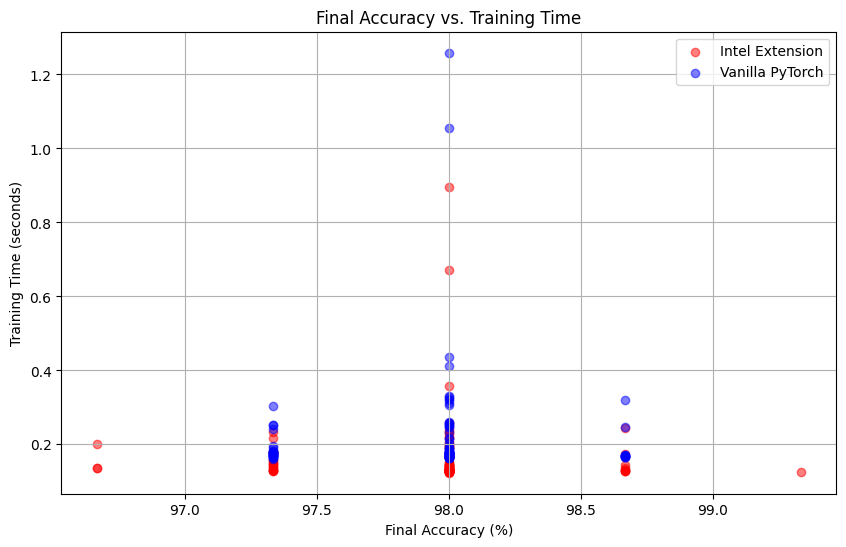

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Function to train the model and measure metrics
def train_model(model, optimizer, criterion, X_train, y_train, num_epochs):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    end_time = time.time()
    training_time = end_time - start_time
    return training_time

# Define constants
num_experiments = 100
num_epochs = 100
input_size = X.shape[1]
hidden_size = 100
num_classes = len(np.unique(y))
lr = 0.001

# Prepare data
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = y

# Initialize lists to store results
final_accuracies = []
training_times = []
optimizers = []

# Run experiments
for i in range(num_experiments):
    # PyTorch version
    model_vanilla = ThreeLayerPerceptron(input_size, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer_vanilla = optim.Adam(model_vanilla.parameters(), lr=lr)
    training_time_vanilla = train_model(model_vanilla, optimizer_vanilla, criterion, torch.FloatTensor(X_train), torch.LongTensor(y_train), num_epochs)
    with torch.no_grad():
        model_vanilla.eval()
        outputs = model_vanilla(torch.FloatTensor(X_train))
        _, predicted = torch.max(outputs, 1)
        accuracy_vanilla = (predicted == torch.LongTensor(y_train)).sum().item() / len(y_train) * 100

    final_accuracies.append(accuracy_vanilla)
    training_times.append(training_time_vanilla)
    optimizers.append('Vanilla PyTorch')

    # Intel Extension for PyTorch version
    model_ipex = ThreeLayerPerceptron(input_size, hidden_size, num_classes)
    optimizer_ipex = optim.Adam(model_ipex.parameters(), lr=lr)
    model_ipex, optimizer_ipex = ipex.optimize(model_ipex, optimizer=optimizer_ipex)
    training_time_ipex = train_model(model_ipex, optimizer_ipex, criterion, torch.FloatTensor(X_train), torch.LongTensor(y_train), num_epochs)
    with torch.no_grad():
        model_ipex.eval()
        outputs = model_ipex(torch.FloatTensor(X_train))
        _, predicted = torch.max(outputs, 1)
        accuracy_ipex = (predicted == torch.LongTensor(y_train)).sum().item() / len(y_train) * 100

    final_accuracies.append(accuracy_ipex)
    training_times.append(training_time_ipex)
    optimizers.append('Intel Extension')

# Plotting
plt.figure(figsize=(10, 6))
colors = {'Vanilla PyTorch': 'blue', 'Intel Extension': 'red'}
for optimizer in set(optimizers):
    indices = [i for i, x in enumerate(optimizers) if x == optimizer]
    plt.scatter(np.array(final_accuracies)[indices], np.array(training_times)[indices], color=colors[optimizer], alpha=0.5, label=optimizer)

plt.title('Final Accuracy vs. Training Time')
plt.xlabel('Final Accuracy (%)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

## Inference - TorchScript Mode
TorchScript mode makes graph optimization possible, hence improves performance for some topologies. Intel® Extension for PyTorch* enables most commonly used operator pattern fusion, and users can get the performance benefit without additional code changes.

Leads to poor performance because - When you freeze the model and trace it with a fixed input shape, you lose the ability to adapt the model to different input sizes during training and inference. This can lead to poor performance, especially if the input data size varies significantly between training and testing datasets.

In [48]:
import os

input_size = 4
hidden_size = 100

# Define a 3-layer Perceptron
class ThreeLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ThreeLayerPerceptron, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        return self.layer3(out)

# Function to train the model and measure metrics
def train_model(model, optimizer, criterion, X_train, y_train, num_epochs):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            # Calculate accuracy
            with torch.no_grad():
                model.eval()
                outputs = model(X_train)
                _, predicted = torch.max(outputs, 1)
                accuracy = (predicted == y_train).sum().item() / len(y_train) * 100

            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

# Function to predict and measure metrics
def predict(model, X_test):
    start_time = time.time()
    with torch.no_grad():
        model.eval()
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
    end_time = time.time()
    prediction_time = end_time - start_time
    print(f"Prediction time: {prediction_time} seconds")


# Vanilla PyTorch version
print("Vanilla PyTorch version:")
X_test_tensor = torch.FloatTensor(X_test)
model_vanilla = ThreeLayerPerceptron(input_size=input_size, hidden_size=hidden_size, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vanilla.parameters(), lr=0.001)
train_model(model_vanilla, optimizer, criterion, X_train_tensor, y_train_tensor, num_epochs=100)
predict(model_vanilla, X_test_tensor)

# Intel Extension for PyTorch optimization
print("\nIntel Extension for PyTorch in TorchScript Mode:")

# Define and optimize the model for training
model_ipex = ThreeLayerPerceptron(input_size=input_size, hidden_size=hidden_size, num_classes=3)
for param in model_ipex.parameters():
    param.requires_grad = True
optimizer_ipex = optim.Adam(model_ipex.parameters(), lr=0.001)
model_ipex, optimizer_ipex = ipex.optimize(model_ipex, optimizer=optimizer_ipex)

# Switch the model to evaluation mode for inference
model_ipex.eval()

# Freeze and trace the model
with torch.no_grad():
    d = torch.randn(X_test.shape, requires_grad=True)
    model_ipex = torch.jit.trace(model_ipex, d)
    model_ipex = torch.jit.freeze(model_ipex)

# Convert to PyTorch tensors and set requires_grad to True
X_train_tensor = torch.FloatTensor(X_train).requires_grad_(True)
y_train_tensor = torch.LongTensor(y_train)

# Train the model
train_model(model_ipex, optimizer_ipex, criterion, X_train_tensor, y_train_tensor, num_epochs=100)

# Perform inference
predict(model_ipex, X_test_tensor)


Vanilla PyTorch version:
Epoch [0/100], Loss: 1.1172, Accuracy: 33.33%
Epoch [10/100], Loss: 0.8033, Accuracy: 89.17%
Epoch [20/100], Loss: 0.5585, Accuracy: 88.33%
Epoch [30/100], Loss: 0.3875, Accuracy: 90.00%
Epoch [40/100], Loss: 0.2781, Accuracy: 92.50%
Epoch [50/100], Loss: 0.2011, Accuracy: 95.00%
Epoch [60/100], Loss: 0.1466, Accuracy: 96.67%
Epoch [70/100], Loss: 0.1112, Accuracy: 96.67%
Epoch [80/100], Loss: 0.0892, Accuracy: 97.50%
Epoch [90/100], Loss: 0.0753, Accuracy: 97.50%
Training time: 0.4574289321899414 seconds
Prediction time: 0.00043463706970214844 seconds

Intel Extension for PyTorch optimization:
Epoch [0/100], Loss: 1.0717, Accuracy: 65.83%
Epoch [10/100], Loss: 1.0717, Accuracy: 65.83%
Epoch [20/100], Loss: 1.0717, Accuracy: 65.83%
Epoch [30/100], Loss: 1.0717, Accuracy: 65.83%
Epoch [40/100], Loss: 1.0717, Accuracy: 65.83%
Epoch [50/100], Loss: 1.0717, Accuracy: 65.83%
Epoch [60/100], Loss: 1.0717, Accuracy: 65.83%
Epoch [70/100], Loss: 1.0717, Accuracy: 65.83

The Intel Extension for PyTorch optimization is a set of tools and techniques designed to enhance the performance of PyTorch models when running on Intel hardware.

- Efficient CPU Utilization: The extension is optimized to take advantage of Intel CPUs' capabilities, including multi-core processing, SIMD instructions, and other hardware features. This ensures that PyTorch models can fully utilize the available CPU resources for improved performance.

- Kernel Optimization: The extension includes optimized implementations of key PyTorch operations (kernels) tailored specifically for Intel CPUs. These optimized kernels are designed to execute more efficiently, reducing computation time and improving overall model performance.

- Memory Optimization: The extension includes memory optimization techniques to minimize memory usage and reduce memory bandwidth requirements. This can lead to improved memory access patterns and better overall performance, especially for memory-bound workloads.

## Why does the inference time for the intel extension sometimes take longer?
While the extension is optimized for CPU utilization, kernel optimization, and memory optimization, these optimizations might require additional computational steps or memory accesses during prediction, leading to longer prediction times compared to vanilla PyTorch.

In [ ]:
!pip install pytorch-lightning

# Intel CPU Training (no TorchScript Mode) + Pytorch Lightning


In [32]:
import time

# Define a PyTorch Lightning module
class ThreeLayerPerceptron(pl.LightningModule):
    def __init__(self, input_size=4, hidden_size=100, num_classes=3):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        return self.layer3(out)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('train_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', accuracy, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

# Define PyTorch Lightning data modules
class IrisDataModule(pl.LightningDataModule):
    def __init__(self, X_train, y_train, X_test, y_test):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(self.X_train), torch.LongTensor(self.y_train)),
            batch_size=32, shuffle=True
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(self.X_test), torch.LongTensor(self.y_test)),
            batch_size=32
        )

# PyTorch Lightning version with Intel Extension for PyTorch optimization
print("\nPyTorch Lightning with Intel Extension for PyTorch optimization:")

# Initialize PyTorch Lightning modules and data modules
model_ipex_pl = ThreeLayerPerceptron(input_size=4, hidden_size=100, num_classes=3)
data_module_pl = IrisDataModule(X_train, y_train, X_test, y_test)

# Set up the trainer
trainer_ipex_pl = pl.Trainer(max_epochs=100)

optimizer_ipex_pl = optim.Adam(model_ipex_pl.parameters(), lr=0.001)

# Optimize the model using Intel Extension for PyTorch (IPEX)
model_ipex_pl, _ = ipex.optimize(model_ipex_pl, optimizer=optimizer_ipex_pl)

# Record start time for training
start_training_time = time.time()

# Train the model using PyTorch Lightning
trainer_ipex_pl.fit(model_ipex_pl, datamodule=data_module_pl)

# Record end time for training
end_training_time = time.time()

# Record start time for prediction
start_prediction_time = time.time()

# Test the model using PyTorch Lightning
test_results = trainer_ipex_pl.test(model_ipex_pl, datamodule=data_module_pl)

# Record end time for prediction
end_prediction_time = time.time()

# Extract loss and accuracy from the test results
loss = test_results[0]["test_loss"]
accuracy = test_results[0]["test_acc"]

# Print the test results in the desired format
for epoch in range(0, len(test_results)):
    loss = test_results[epoch]["test_loss"]
    accuracy = test_results[epoch]["test_acc"]
    print(f"Epoch [{epoch * 10}/{100}], Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%")

# Add training time and prediction time
training_time = end_training_time - start_training_time
prediction_time = end_prediction_time - start_prediction_time
print(f"Training time: {training_time:.9f} seconds")
print(f"Prediction time: {prediction_time:.9f} seconds")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params
----------------------------------
0 | layer1 | Linear | 500   
1 | relu   | ReLU   | 0     
2 | layer2 | Linear | 10.1 K
3 | layer3 | Linear | 303   
----------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)



PyTorch Lightning with Intel Extension for PyTorch optimization:


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.019714510068297386    │
└───────────────────────────┴───────────────────────────┘

Epoch [0/100], Loss: 0.0197, Accuracy: 100.00%
Training time: 16.280878305 seconds
Prediction time: 0.075366735 seconds
